<a href="https://colab.research.google.com/github/guillermohenrion/Intro-Python/blob/master/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [194]:
import sklearn.datasets as datasets
import pandas as pd
import random
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.datasets import make_blobs
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
from google.colab import files
uploaded=files.upload()

Saving datasets_89775_207354_play_tennis.csv to datasets_89775_207354_play_tennis.csv


In [98]:
pt = pd.read_csv('datasets_89775_207354_play_tennis.csv')
pt.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes
5,D6,Rain,Cool,Normal,Strong,No
6,D7,Overcast,Cool,Normal,Strong,Yes
7,D8,Sunny,Mild,High,Weak,No
8,D9,Sunny,Cool,Normal,Weak,Yes
9,D10,Rain,Mild,Normal,Weak,Yes


[0 1]
{'priors': [0.35714285714285715, 0.6428571428571429], 'var_smoothing': 1e-09}
[[1.6        1.2        0.2        0.4       ]
 [0.66666667 1.66666667 0.5        0.66666667]]


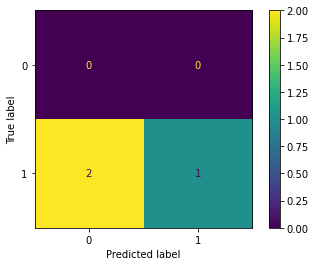

In [151]:
le = [LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder(), LabelEncoder()]
x=pd.DataFrame()
col=pt.columns

i=0
for item in pt:
  if item=='day':
    x[item]=[valor.replace('D','') for valor in pt['day']]
  else:
    lei=le[i].fit(pt[item])
    x[item]=lei.transform(pt[item])
    i=i+1

X_train, X_test, y_train, y_test = train_test_split(x[col[1:5]], x.play, test_size=0.2, random_state=0)


#gnb = GaussianNB()
gnb = GaussianNB(priors=[5/14, 9/14])
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print(gnb.classes_)
print(gnb.get_params())
print(gnb.theta_) #Mean of each feature per class
predictions=gnb.predict(X_test)
plot_confusion_matrix(gnb, X_test, y_test)


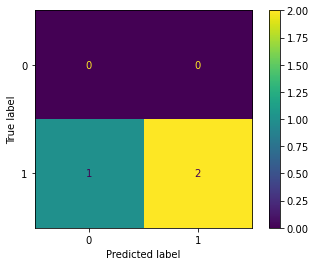

In [152]:
gnb = CategoricalNB ()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
gnb.classes_
gnb.get_params()

predictions=gnb.predict(X_test)
plot_confusion_matrix(gnb, X_test, y_test)

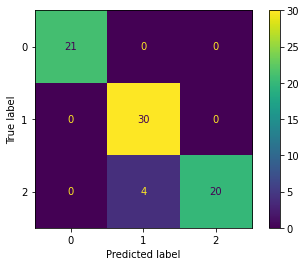

In [154]:

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

plot_confusion_matrix(gnb, X_test, y_test)

In [180]:
x, y = make_blobs(n_samples=10000,centers=5,random_state=1234)
dataset = pd.DataFrame(x)
dataset['target'] = y

,0,1,target
0,-0.093391,6.946645,1
1,-0.071890,3.511294,1
2,5.423476,-3.564840,2
3,-5.453127,6.176981,3
4,9.648590,8.020132,4
...,...,...,...
9995,-4.312784,5.553852,3
9996,-4.499795,4.394647,3
9997,-3.817329,8.154037,3
9998,-5.997647,1.602026,0


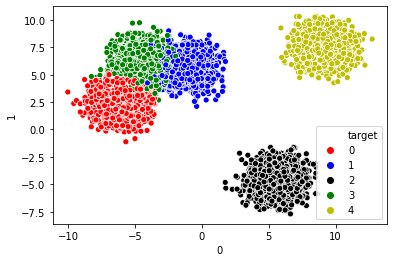

In [159]:
sns.scatterplot(x=0,y=1,hue='target',palette={0:'r',1:'b',2:'k',3:'g',4:'y'},data=dataset)

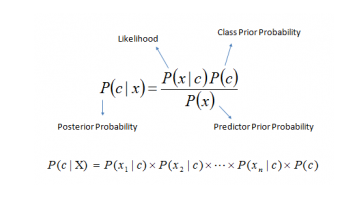

In [187]:
def prob_standard_normal(x):
  return np.exp(-0.5*x**2)/np.sqrt(2*np.pi)

def prob_normal(x,mean,std):
  return prob_standard_normal((x-mean)/std)/std

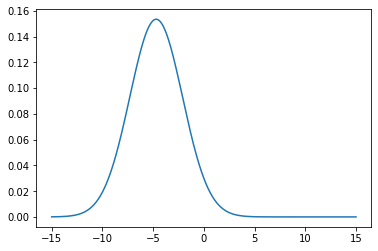

In [188]:
#@title Distribución normal
mean = -4.7 #@param {type:"slider", min:-10, max:10, step:0.1}
std = 2.6 #@param {type:"slider", min:0, max:5, step:0.1}

x = np.linspace(-15,15,1000)
plt.plot(x,prob_normal(x,mean,std))

In [175]:
def fit_gaussiannb(dataset):
  priors = dataset['target'].value_counts(normalize=True)
  means = dataset.groupby('target').mean()
  stds = dataset.groupby('target').std()

  return priors,means,stds

def get_likelihoods(x,means,stds):
  features = means.columns
  target_names = means.index
  likelihoods = []
  for target in target_names:
    likelihood_target = 1
    for i,feat in enumerate(features):
      std = stds[feat].loc[target]
      mean = means[feat].loc[target]
      likelihood_target = likelihood_target*prob_normal(x[i],mean,std)
    likelihoods.append(likelihood_target)
  return likelihoods, target_names

def get_posteriors(x,means,stds,priors):
  likelihoods, target_names = get_likelihoods(x,means,stds)
  posteriors = likelihoods*priors
  return posteriors, target_names

def predict(x,means,stds,priors):
  posteriors, target_names = get_posteriors(x,means,stds,priors)
  return target_names[np.argmax(posteriors)]

In [186]:
test_set = dataset.sample(1000)
train_set = dataset.loc[~dataset.index.isin(test_set.index)]

priors,means,stds = fit_gaussiannb(train_set)
y_true = test_set.target.values
x_test = test_set.drop('target',axis=1).values

y_pred = [predict(x,means,stds,priors) for x in x_test]

print(classification_report(y_true,y_pred))

,0,1
target,,
0,-6.168154,2.474736
1,-1.227859,5.724803
2,5.617519,-4.544422
3,-4.458635,6.025878
4,9.133746,7.519525


In [166]:
#Armado de la grilla:
grid = np.meshgrid(np.arange(-10,10,0.5),np.arange(-10,10,0.4))
x_vals = grid[0].reshape(-1,1)
y_vals = grid[1].reshape(-1,1)

#Armo un dataframe datos_frontera con todos los puntos de la grilla.
datos_frontera = pd.DataFrame(np.concatenate([x_vals,y_vals],axis=1))

In [167]:
gnb_sklearn = GaussianNB()
gnb_sklearn.fit(train_set.drop('target',axis=1).values,train_set.target.values)
predictions = gnb_sklearn.predict(datos_frontera.values)

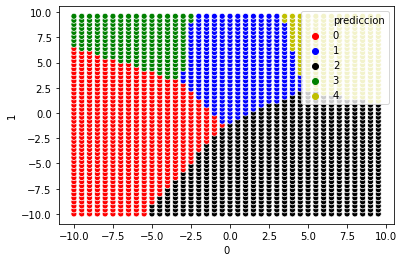

In [168]:
datos_frontera['prediccion'] = predictions
sns.scatterplot(x=0,y=1,hue='prediccion',data=datos_frontera,palette={0:'r',1:'b',2:'k',3:'g',4:'y'})

In [190]:
from google.colab import files
uploaded=files.upload()

Saving datasets_483_982_spam.csv to datasets_483_982_spam.csv


In [199]:
spam_dataset = pd.read_csv('datasets_483_982_spam.csv', encoding='latin-1')[['v1','v2']]

,v1,v2,is_spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,1
5568,ham,Will Ì_ b going to esplanade fr home?,0
5569,ham,"Pity, * was in mood for that. So...any other s...",0
5570,ham,The guy did some bitching but I acted like i'd...,0


In [195]:
spam_dataset['is_spam'] = (spam_dataset['v1'] == 'spam').astype(int)
spam_dataset['is_spam'].value_counts()
target = spam_dataset['is_spam'].values

In [196]:
bagger = CountVectorizer()
bow = bagger.fit_transform(list(spam_dataset['v2']))

In [197]:
nb = MultinomialNB()
x_train, x_test, y_train, y_test = train_test_split(bow,target,test_size=0.3,stratify=target)

nb.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [198]:
y_pred = nb.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1448
           1       0.91      0.95      0.93       224

    accuracy                           0.98      1672
   macro avg       0.95      0.97      0.96      1672
weighted avg       0.98      0.98      0.98      1672

